# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

## Inngangur:

### Open Street Map

In [1]:
from straeto.data import get_osm_data

#get_osm_data(verbose=True)

In [2]:
!printf 'osm-data:\n' && ls osm-data/ && printf '\nosm-data/output:\n' && ls osm-data/output

osm-data:
gis_osm_roads_free_1.cpg  gis_osm_roads_free_1.prj  gis_osm_roads_free_1.shx
gis_osm_roads_free_1.dbf  gis_osm_roads_free_1.shp  output

osm-data/output:
extracted_roads.cpg  extracted_roads.shx     no_extracted_roads.shp
extracted_roads.dbf  no_extracted_roads.cpg  no_extracted_roads.shx
extracted_roads.prj  no_extracted_roads.dbf
extracted_roads.shp  no_extracted_roads.prj


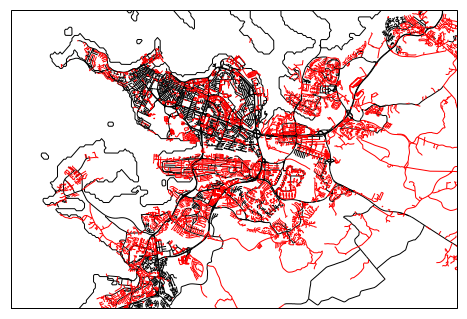

In [3]:
from straeto import straeto
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = straeto.get_map(region='reykjavik', res='f', zoom=1.5)

ax = straeto.add_shapefile(ax, 'osm-data/output/extracted_roads.shp')
ax = straeto.add_shapefile(ax, 'osm-data/output/no_extracted_roads.shp', edgecolor='red')

plt.show()

### API
Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [4]:
from straeto import api
api.getBusPositionsFor(["1", "55"])[0]

{'deviceNumber': 80,
 'route': '1-D',
 'gpsTime': '180529232434',
 'lat': 64.0546433333333,
 'lon': -21.9665833333333,
 'speed': 14.21,
 'heading': 235.45,
 'gpsFix': 2,
 'routeNumber': '1',
 'lastStop': 14001620,
 'nextStop': 14001612,
 'pingCode': 6}

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

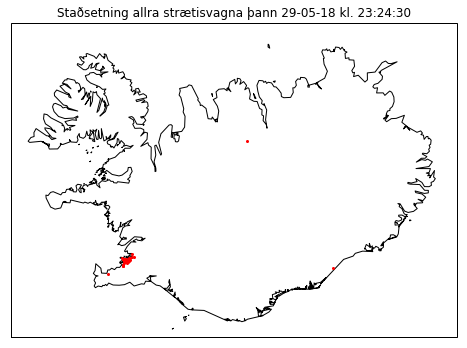

In [5]:
from datetime import datetime

fig, ax = straeto.get_map(region='iceland')

for bus in api.getAllBusPositions():
    plt.plot(bus['lon'], bus['lat'], marker='o', color='red', markersize=2,
             transform=ccrs.Geodetic())

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

Hraðinn er einnig til staðar en ekki vitum við þó hvaða mælieining notuð er til þess að mæla hann.

$k\cdot v_{api} = v \Rightarrow k = \frac{v}{v_{api}}$

In [6]:
from straeto import straeto
bdict, p_bdict = straeto.getConsecutiveBuses(ratio=0.5)

print(len(bdict),len(p_bdict))

37 37


In [7]:
from geopy.distance import geodesic
from datetime import datetime as dt
G = []
B = []
Ks = []
for key in bdict:
    bus = bdict[key]; p_bus = p_bdict[key]
    t_1 = dt.strptime(bus['gpsTime'],"%y%m%d%H%M%S"); t_2 = dt.strptime(p_bus['gpsTime'],"%y%m%d%H%M%S")
    delta_t = (t_1-t_2).total_seconds()
    delta_s = geodesic((bus['lat'], bus['lon']), (p_bus['lat'], p_bus['lon'])).km

    kmh = (delta_s/delta_t)*3600
    avg_speed = (1/2)*(bus['speed']+p_bus['speed'])

    k = kmh/avg_speed
    Ks.append(k)
    dic = {
        'speed_0': p_bus['speed'],
        'speed_1': bus['speed'],
        'delta_s': delta_s,
        'delta_t': delta_t,
        'kmh': kmh,
        'avg_speed': avg_speed,
        'route': bus['route'],
        'k': k
    }
    if 1.7 < k < 1.9:
        G.append(dic)
    else:
        B.append(dic)

print('Good:')
for i in G:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
print('Bad:')
for i in B:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
avg_k = sum(Ks)/len(Ks)
print(avg_k)


Good:
28-A | k = 25.97 / 15.0 = 1.73 | 15.43 --> 14.57
4-B | k = 48.92 / 28.32 = 1.73 | 31.04 --> 25.61
36-A | k = 35.4 / 19.46 = 1.82 | 19.5 --> 19.43
5-C | k = 38.19 / 20.73 = 1.84 | 18.18 --> 23.27
43-A | k = 28.32 / 16.55 = 1.71 | 20.51 --> 12.59
1-C | k = 20.61 / 11.72 = 1.76 | 7.92 --> 15.53
55-A | k = 96.45 / 51.28 = 1.88 | 51.72 --> 50.84
24-B | k = 29.79 / 16.43 = 1.81 | 23.32 --> 9.53
43-B | k = 61.69 / 32.8 = 1.88 | 33.44 --> 32.17
11-C | k = 40.35 / 21.8 = 1.85 | 20.81 --> 22.79
57-C | k = 99.09 / 53.44 = 1.85 | 53.11 --> 53.76
57-A | k = 74.54 / 40.65 = 1.83 | 40.95 --> 40.34
15-D | k = 60.57 / 32.58 = 1.86 | 33.17 --> 31.99
51-D | k = 97.3 / 52.72 = 1.85 | 52.66 --> 52.78
Bad:
1-D | k = 30.75 / 14.53 = 2.12 | 11.91 --> 17.15
15-C | k = 41.72 / 21.46 = 1.94 | 17.94 --> 24.99
12-D | k = 32.93 / 15.3 = 2.15 | 9.98 --> 20.62
2-B | k = 35.21 / 16.84 = 2.09 | 14.44 --> 19.24
11-A | k = 40.84 / 20.76 = 1.97 | 22.94 --> 18.58
5-B | k = 32.01 / 16.48 = 1.94 | 16.68 --> 16.29
18-A 

## Undirbúningur gagna:
Load sqlite files:
```
pgloader 25-03-2018.db postgresql:///straeto
```
Started 22:37
```
UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r ORDER BY b.geom <-> r.geom LIMIT 1);
```
Aðeins hraðara: (37-39 sec með index)
```
UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r WHERE ST_Expand(b.geom, 0.012) && r.geom ORDER BY b.geom <-> r.geom LIMIT 1);
```

In [8]:
%alias sql psql straeto -c

In [9]:
sql "\dt"

            List of relations
 Schema |      Name       | Type  | Owner 
--------+-----------------+-------+-------
 public | buses           | table | arni
 public | roads           | table | arni
 public | spatial_ref_sys | table | arni
(3 rows)



In [10]:
#sql "ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);"

In [11]:
#sql "UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);"

In [12]:
#sql "CREATE INDEX buses_gix ON buses USING gist(geom);"

In [13]:
#sql "VACUUM ANALYZE;"

In [14]:
#sql "ALTER TABLE buses ADD maxspeed integer;"

## Úrvinnsla gagna:

In [15]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql

connection = pg.connect(database='straeto',
                        # Location of .s.PGSQL.5432 file;
                        # try host='/tmp' if you get an error.
                        host='/var/run/postgresql')
df = pd_sql.read_sql("SELECT gps_time, route_number, lat, lon, speed, maxspeed FROM buses;", connection)

In [16]:
df['gps_time'] = pd.to_datetime(df['gps_time'], format='%y%m%d%H%M%S')
df['speed'] = df['speed']*1.85

In [17]:
df = df.set_index('gps_time')

In [18]:
df.head(3)

,route_number,lat,lon,speed,maxspeed
gps_time,,,,,
2018-03-24 23:58:05,12,64.1280,-21.9471,0.0000,0
2018-03-24 23:58:07,3,64.1330,-21.8965,50.9675,60
2018-03-24 23:58:06,7,64.1689,-21.6923,19.9615,30


In [19]:
df = df.query('maxspeed > 0')
df['ratio'] = df['speed']/df['maxspeed']

In [20]:
over = df.query('maxspeed < speed')
under = df.query('maxspeed >= speed')

In [21]:
df.head(8)

,route_number,lat,lon,speed,maxspeed,ratio
gps_time,,,,,,
2018-03-24 23:58:07,3,64.1330,-21.8965,50.9675,60,0.849458
2018-03-24 23:58:06,7,64.1689,-21.6923,19.9615,30,0.665383
2018-03-24 23:58:05,15,64.1455,-21.9677,28.3235,30,0.944117
2018-03-24 23:58:05,12,64.1243,-21.8482,61.3645,60,1.022742
2018-03-24 23:58:05,15,64.1628,-21.7282,27.5465,50,0.550930
2018-03-24 23:58:05,3,64.1455,-21.9245,22.2555,30,0.741850
2018-03-24 23:58:08,18,64.1287,-21.7731,68.9495,80,0.861869
2018-03-24 23:58:07,28,64.1101,-21.8880,24.6790,50,0.493580


In [22]:
print(len(over), len(under), round(len(over)*100/len(under), 1))

64434 331371 19.4


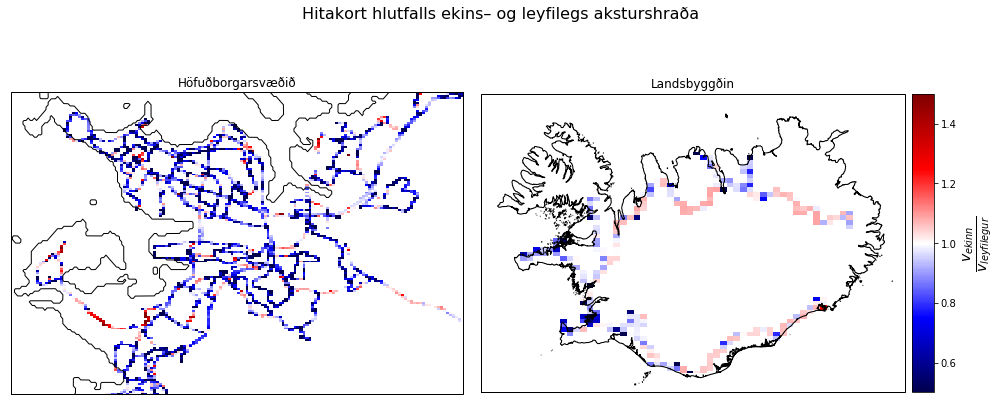

In [23]:
%matplotlib inline
import numpy as np
from scipy.stats import binned_statistic_2d
from mpl_toolkits.axes_grid1 import make_axes_locatable

x = df['lon']
y = df['lat']
ratios = df['ratio']

fig, (ax, ax2) = straeto.get_map(region=[['reykjavik', 1.15], 'iceland'], res='f',
                                 figsize=(14, 7), shape=(1, 2))

# Heatmap
vmin, vmax= 0.5, 1.5

ax.set_title('Höfuðborgarsvæðið')
heatmap, x_edges, y_edges, _ = binned_statistic_2d(x, y, ratios, bins=4000, statistic='mean')
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
im = ax.imshow(heatmap.T, cmap='seismic', vmin=vmin, vmax=vmax,
               extent=extent, origin='lower', transform=ccrs.PlateCarree())

ax2.set_title('Landsbyggðin')
heatmap, x_edges, y_edges, _ = binned_statistic_2d(x, y, ratios, bins=50, statistic='mean')
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
im = ax2.imshow(heatmap.T, cmap='seismic', vmin=vmin, vmax=vmax,
                extent=extent, origin='lower', transform=ccrs.PlateCarree())

# Colourbar
divider = make_axes_locatable(ax2)
cax = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('$\\frac{v_{ekinn}}{v_{leyfilegur}}$', size=20)

fig.suptitle('Hitakort hlutfalls ekins– og leyfilegs aksturshraða', size=16)
fig.tight_layout()
plt.subplots_adjust(top=1)
plt.show()